In [1]:
import numpy as np
exp = np.exp
arange = np.arange
ln = np.log
from datetime import *

import matplotlib.pyplot as plt
from matplotlib import patches

import plotly.plotly as py
import plotly.graph_objs as go

from scipy.stats import norm
from scipy import interpolate as interp
pdf = norm.pdf
cdf = norm.cdf
ppf = norm.ppf

from scipy import stats
from scipy import special
erf = special.erf

import pandas as pd
import palettable
import seaborn as sns
cp = sns.color_palette()

from lifelines import KaplanMeierFitter
from sklearn.metrics import brier_score_loss
from sklearn.linear_model import LogisticRegression
from sklearn import mixture
from sklearn import preprocessing

In [29]:
nsclc = pd.read_csv('/Users/geoffreysedor/Documents/nsclc_data.csv')

lc_df = pd.read_csv('/Users/geoffreysedor/Documents/lc_data.csv')

## kde / cdf functions

In [4]:
def create_kde(array, bandwidth=None):
    """ calculating KDE and CDF using scipy """
    if bandwidth == None:
        bw = 'scott'
    else:
        bw = bandwidth
    kde = stats.gaussian_kde(dataset=array,bw_method=bw)
    
    num_test_points=200
    x = np.linspace(0,np.max(array)*1.2,num_test_points)
    kdens=kde.pdf(x)
    
    cdf=np.zeros(shape=num_test_points)
    for i in range(num_test_points):
        cdf[i] = kde.integrate_box_1d(low=0,high=x[i])
        
    return x,kdens,cdf


def calc_cdf(array,var,bandwidth=None):
    if bandwidth == None:
        bw = 1.2*array.std()*np.power(array.size,-1/5)
    else:
        bw = bandwidth
    kde=stats.gaussian_kde(dataset=array,bw_method=bw)
    return kde.integrate_box_1d(low=0,high=var)




## NTCP adjustments:

In [14]:
def prob_pneumonitis(dose_h, dose_l = 0):
    fx_to_lung = 8.5
    MLDh = dose_h/fx_to_lung
    MLDl = dose_l/fx_to_lung
    b0 = -3.87
    b1 = 0.126
    prob_h = np.exp(b0+b1*MLDh)/(1+np.exp(b0+b1*MLDh))
    if np.all(dose_l==0):
        prob_l = np.exp(b0+b1*MLDl)/(1+np.exp(b0+b1*MLDl))
    else:
        prob_l = np.zeros(dose_l.size)
    return prob_h, prob_l

def pneumonitis_RR(dose_h, dose_l = 0):
    prob_h, prob_l = prob_pneumonitis(dose_h,dose_l)
    rr = (1+prob_h)/(1+prob_l)
    return np.round(rr,3)

def prob_esoph(dose_h, dose_l = 0):
    EUD1 = dose_h/4
    EUD2 = dose_l/4
    TD50 = 47
    m = 0.36
    t1 = (EUD1-TD50)/(m*TD50)
    t2 = (EUD2-TD50)/(m*TD50)
    y = (erf(t1)-erf(t2))/2
    return np.round(y,3)

def esophagitis_RR(dose_h, dose_l = 0):
    
    prob_h = prob_esoph(dose_h)
    prob_l = prob_esoph(dose_l)
    rr = (1+prob_h)/(1+prob_l)
    return np.round(rr,4)

def cardiac_event_RR(dose_h, dose_l = 0):
    
    dose_diff = dose_h-dose_l
    delta_dose_heart = np.mean((dose_h-dose_l)/14)
    risk_per_gy = np.zeros(len(t))
    risk_per_gy = np.where(t<5,16.3,0)
    risk_per_gy = np.where(5<=t,15.5,risk_per_gy)
    risk_per_gy = np.where(t>=10,1.2,risk_per_gy)
    #risk_per_gy = 7.4    #  percent increased risk
    cardiac_event_rr = 1+risk_per_gy*delta_dose_heart/100
#     cardiac_event_rr = 1+.074*delta_dose_heart
    
    return cardiac_event_rr


In [32]:
def H_esoph(dose_h, dose_l = 0, CI = None):
    EUD1 = dose_h/4
    EUD2 = dose_l/4
    TD50 = 47
    TD50l = 60
    TD50u = 41
    
    m = 0.36
    mu = 0.55
    ml = 0.25
    
    if CI == 'upper':
        TD50 = TD50u
        m = mu
    elif CI == 'lower':
        TD50 = TD50l
        m = ml
        
    t1 = (EUD1-TD50)/(m*TD50)
    t2 = (EUD2-TD50)/(m*TD50)
    y = (erf(t1)-erf(t2))/2
    return np.round(y,3)

def H_lung(dose_h, dose_l = 0, CI = None):
    fx_to_lung = 1/8.5
    MLDh = dose_h*fx_to_lung
    MLDl = dose_l*fx_to_lung
    b0 = -3.87
    b0u = -3.33
    b0l =  -4.49
    
    b1 = 0.126
    b1u = .153
    b1l = .100

    if CI == 'upper':
        b0 = b0u
        b1 = b1u
    elif CI == 'lower':
        b0 = b0l
        b1 = b1l
    
    prob_h = np.exp(b0+b1*MLDh)/(1+np.exp(b0+b1*MLDh))
    if np.all(dose_l==0):
        prob_l = np.exp(b0+b1*MLDl)/(1+np.exp(b0+b1*MLDl))
    else:
        prob_l = np.zeros(dose_l.size)
    return prob_h - prob_l

def RH_cardiac(d,CI=None):
    d=d/14
    if CI =='upper':
        RR = 1 + .643*d
    elif CI == 'lower':
        RR = 1 + .03*d
    else:
        RR = 1 + .163*d
    return RR

def RH_cardiac_20yr(d,CI=None):
    d=d/14
    if CI =='upper':
        RR = 1 + .074*d
    elif CI == 'lower':
        RR = 1 + .029*d
    else:
        RR = 1 + .145*d
    return RR



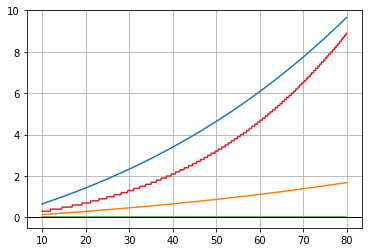

In [38]:
d = np.arange(10,80,.1)
p = 100*(prob_pneumonitis(d)[0]-prob_pneumonitis(d)[1])
p2 = 100*H_lung(d,CI='upper')
p3 = 100*H_lung(d,CI='lower')
e = 100*prob_esoph(d)
e2 = 100*H_esoph(d,CI='lower')
e3 = 100*H_esoph(d,CI='upper')
c = .074*d/14

fig,ax = plt.subplots()

ax.plot(d,p2,d,p3)
ax.plot(d,e2,d,e3)

ax.set_ylim(-.5,10)
ax.grid(True)
ax.axhline(y=0,c='k',lw=1)


0.98519892427296
0.9241615463007095
-0.5353474672908778 [0.05675477]
[-1.09999658] [[0.02597576]]


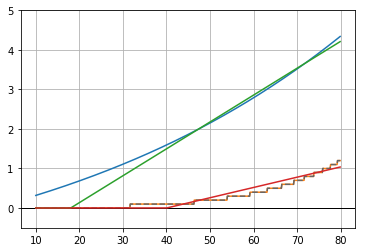

In [31]:
d = np.arange(10,80,.1)
p = 100*(prob_pneumonitis(d)[0]-prob_pneumonitis(d)[1])
e = 100*prob_esoph(d)
e_0 = 100*H_esoph_0(d)
c = .074*d/14

fig,ax = plt.subplots()
ax.plot(d,p)
ax.plot(d,e)
ax.plot(d,e_0, color=(.4,.4,.4),ls='--')

ax.set_ylim(-.5,5)
ax.grid(True)
ax.axhline(y=0,c='k',lw=1)

from sklearn.linear_model import LinearRegression

lr = LinearRegression()
d=d.reshape(-1,1)
lr.fit(d,p)
print(lr.score(d,p))

d2 = np.arange(40,80,.1)
d2=d2.reshape(-1,1)
e2 = 100*prob_esoph(d2)
lr2 = LinearRegression()
lr2.fit(d2,e2)
print(lr2.score(d2,e2))

print(lr.intercept_,lr.coef_)
print(lr2.intercept_,lr2.coef_)

def risk_p(dose):
    d = np.maximum(dose-18,0)
    r = d*0.068
    return r
def risk_e(dose):
    d = np.maximum(dose-40,0)
    r = 0.026*d
    return r

ax.plot(d,risk_p(d))
ax.plot(d,risk_e(d))

In [28]:

from scipy.stats import norm

def H_esoph(dose):
    y=norm.cdf(dose/4,51,14)
    return y


def H_lung(dose_h, dose_l = 0, CI = None):
    fx_to_lung = 1/8.5
    MLDh = dose_h*fx_to_lung
    MLDl = dose_l*fx_to_lung
    b0 = -3.87
    b0u = -3.33
    b0l =  -4.49
    
    b1 = 0.126
    b1u = .153
    b1l = .100
    
    # TD50 = 30.75 [28.7–33.9] Gy
    if CI == 'upper':
        b0 = b0u
        b1 = b1u
    elif CI == 'lower':
        b0 = b0l
        b1 = b1l
    
    prob_h = np.exp(b0+b1*MLDh)/(1+np.exp(b0+b1*MLDh))
    if np.all(dose_l==0):
        prob_l = np.exp(b0+b1*MLDl)/(1+np.exp(b0+b1*MLDl))
    else:
        prob_l = np.zeros(dose_l.size)
    return prob_h - prob_l

def risk_p(dose):
    d = np.maximum(dose-18,0)
    r = d*0.068
    return r
def risk_e(dose):
    d = np.maximum(dose-40,0)
    r = 0.026*d
    return r

In [46]:
def risk_p(dose):
    r = H_lung(dose)
    return r
def risk_e(dose):
    r = H_esoph(dose)
    return r

## fig 4

### tcc hist with percentages (first panel)

Text(0.5,0,'RxRSI for TCC Lung')

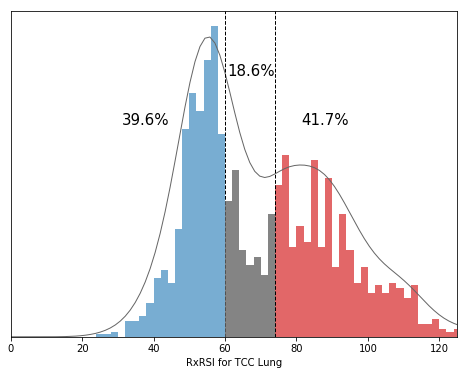

In [10]:
r = nsclc.rsi

d = 2
beta = 0.05

# for SF2 alpha
n = 1
alpha_tcc = (np.log(r)+beta*n*(d**2))/(-n*d)
rxdose_tcc = 33/(alpha_tcc+beta*d)
rxdose_tcc=rxdose_tcc.values

""" plotting histograms """
fig, ax = plt.subplots(figsize=(8,6))
binlist=list(np.arange(0,150,2))+[300]

""" <60 range """
xdata = rxdose_tcc[np.where(rxdose_tcc<60)]
wts =  np.full(len(xdata),.0002)
ax.hist(xdata,bins = binlist,
        alpha=.6,#ec = 'k',
        color=cp[0],  
        weights = wts)

""" 60-74 range """
xdata = rxdose_tcc[np.where((rxdose_tcc>60)&(rxdose_tcc<74))]
wts =  np.full(len(xdata),.0002)
ax.hist(xdata,bins = binlist,
        alpha=.8,#ec = 'k',
        color=(.4,.4,.4),  
        weights = wts,zorder=5)

""" >74 range """
xdata = rxdose_tcc[np.where((rxdose_tcc>74))]  #&(rxdose_tcc<80))]
wts =  np.full(len(xdata),.0002)
ax.hist(xdata,bins = binlist,
        alpha=.7,#ec = 'k',
        color=cp[3],  
        weights = wts)

rxdose_kde = create_kde(rxdose_tcc,bandwidth=.15)

pp_60 = np.where(rxdose_kde[0]<=60,rxdose_kde[2],0).max()
pp_74 = np.where(rxdose_kde[0]<=74,rxdose_kde[2],0).max()
pp_60_74 = pp_74 - pp_60
pp_over_74 = 1 - pp_74

rxdose_kde = create_kde(rxdose_tcc,bandwidth=.26)
ax.plot(rxdose_kde[0], rxdose_kde[1] , c=(.4,.4,.4),lw=1,ls='-',label = 'KDE')

ax.text(.25,.65,'{:0.1f}%'.format(pp_60*100), transform=ax.transAxes, fontsize=15)
ax.text(.485,.8,'{:0.1f}%'.format(pp_60_74*100), transform=ax.transAxes,fontsize=15)
ax.text(.65,.65,'{:0.1f}%'.format(pp_over_74*100), transform=ax.transAxes,fontsize=15)

ax.axvline(x = 60,c='k',lw=1,ls='--')
ax.axvline(x = 74,c='k',lw=1,ls='--')


ax.set_xlim(0,125)
ax.set_yticks([])
ax.set_xlabel('RxRSI for TCC Lung')


## 60 pt group outcome analysis

In [11]:
from lifelines import KaplanMeierFitter
from lifelines import WeibullFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

### km fits

In [13]:
T = lc_df['td_yrs'].values
E = lc_df['LocalFailure'].values

idx = lc_df.gardtx>=33
T1 = T[idx]
T2 = T[~idx]
E1 = E[idx]
E2 = E[~idx]

km1 = KaplanMeierFitter()
km1.fit(T1, event_observed = E1, label = 'KM GARD>33')
km2 = KaplanMeierFitter()
km2.fit(T2, event_observed = E2, label = 'KM GARD<33')
km_all = KaplanMeierFitter()
km_all.fit(T, event_observed = E, label = 'KM All')


<lifelines.KaplanMeierFitter: fitted with 60 observations, 37 censored>

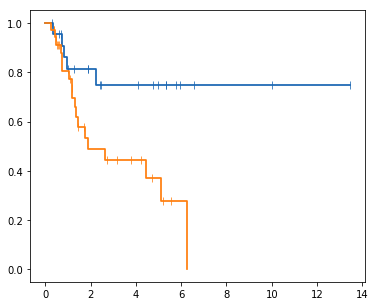

In [14]:
survtable1 = km1.survival_function_
S_km1 = survtable1.values
t_1 = survtable1.index.values

survtable2 = km2.survival_function_
S_km2 = survtable2.values
t_2 = survtable2.index.values

t1_cens = T1[np.where(E1!=1)]
C1 = survtable1.loc[t1_cens]
t2_cens = T2[np.where(E2!=1)]
C2 = survtable2.loc[t2_cens]

fig,ax = plt.subplots(figsize=(6,5))

col = (.1,.4,.7)
ax.step(t_1,S_km1,where = 'post',color=col,lw=1.75)
ax.scatter(t1_cens,C1,marker='|',color=col,s=50,lw=.75)

col  = cp[1]
ax.step(t_2,S_km2,where = 'post',color=col,lw=1.75)
ax.scatter(t2_cens,C2,marker='|',color=col,s=50,lw=.75)


In [15]:

T = lc_df['td_yrs']
E = lc_df['LocalFailure']
gard=lc_df['gardtx']
idx = gard>33

T1 = T[idx]
T2 = T[~idx]
E1 = E[idx]
E2 = E[~idx]

wf0 = WeibullFitter()
wf0.fit(T,E)
wf1 = WeibullFitter()
wf1.fit(T1, E1)
wf2 = WeibullFitter()
wf2.fit(T2, E2)

def S1(t):
    return wf1.predict(t)
def S2(t):
    return wf2.predict(t)

pd.concat([wf1.summary, wf2.summary, wf0.summary],axis=0)

,coef,se(coef),lower 0.95,upper 0.95,p,log(p)
lambda_,0.028907,0.031472,-0.032778,0.090592,3.583617e-01,-1.026213
rho_,0.641806,0.249405,0.152980,1.130631,1.007207e-02,-4.597989
lambda_,0.263115,0.054388,0.156517,0.369713,1.313162e-06,-13.543073
rho_,1.161710,0.211020,0.748119,1.575301,3.687074e-08,-17.115848
lambda_,0.138253,0.035985,0.067724,0.208782,1.220452e-04,-9.011119
rho_,0.893703,0.148328,0.602987,1.184420,1.689033e-09,-20.199110


### wbl fit for gard 33 cutpoint

In [16]:
def S1(t):
    lambda_ = 0.028907
    rho_ = 0.641806
    y = np.exp(-1*np.power(lambda_*t,rho_))
    return y

def S2(t):
    lambda_ = 0.263115
    rho_ = 1.161710
    y = np.exp(-1*np.power(lambda_*t,rho_))
    return y

### trials of escalation (panels 2 & 3)

In [17]:

def calc_rxdose(rsi_array):
    d = 2
    beta = 0.05
    n = 1
    alpha_array = (ln(rsi_array)+beta*n*(d**2))/(-n*d)
    rxdose_array = 33/(alpha_array+beta*d)
    return rxdose_array

def percentile(array,val):
    pp = np.argwhere(array<=val).size/array.size
    return pp

""""------------------------------------------------"""

trials = 100
num_pts = 200
t=np.arange(0,10,.1)

rsi_cohort = np.zeros(num_pts)
rxdose = np.zeros(num_pts)

results_1 = np.zeros(shape=(trials,len(t)))
results_2 = np.zeros(shape=(trials,len(t)))
results_3 = np.zeros(shape=(trials,len(t)))
results_4 = np.zeros(shape=(trials,len(t)))

for i in range(trials):
    rsi_cohort = np.random.choice(r,num_pts)
    
    cohort_1 = calc_rxdose(np.random.choice(r,num_pts))    # 60 Gy arm
    cohort_2 = calc_rxdose(np.random.choice(r,num_pts))    # selective escalation

    """case 1: 60 vs. selected escalation to 74"""

    C1 = percentile(cohort_1,60)
    C2 = 1 - C1
    lc_cohort_1 = C1*S1(t) + C2*S2(t)

    C1 = percentile(cohort_2,74)
    C2 = 1 - C1
    lc_cohort_2 = C1*S1(t) + C2*S2(t)

    dose_cohort_2 = np.where((cohort_2>60) & (cohort_2<=74), 74, 60)
    average_dose_cohort2 = np.mean(dose_cohort_2)
    
    risk60 = (risk_p(60)+risk_e(60))/100
    plc_cohort_1 = np.power(lc_cohort_1,np.exp(risk60))#*(1+60/14*0.074))

    risk6074 = (risk_p(average_dose_cohort2)+risk_e(average_dose_cohort2))/100
    plc_cohort_2 = np.power(lc_cohort_2,np.exp(risk6074)*(1+(average_dose_cohort2-60)/14*0.074))
    
    results_1[i,:] = plc_cohort_1
    results_2[i,:] = plc_cohort_2
    
    """case 1.5 -> 60 vs 60-74"""
    
    dose_cohort_4 = np.where((cohort_2>60) & (cohort_2<=74), cohort_2, 60)
    average_dose_cohort4 = np.mean(dose_cohort_4)
    risk60_thru_74 = (risk_p(average_dose_cohort4)+risk_e(average_dose_cohort4))/100
    #plc_cohort_4 = np.power(lc_cohort_4,np.exp(risk6074)*(1+average_dose_cohort2/14*0.074))
    plc_cohort_4 = np.power(lc_cohort_2,np.exp(risk60_thru_74)*(1+(average_dose_cohort4-60)/14*0.074))
    results_4[i,:] = plc_cohort_4

    """case 2: 60 vs. 45-80"""
    cohort_3 = calc_rxdose(np.random.choice(r,num_pts))    # precision dosing

    C1 = percentile(cohort_1,80)
    C2 = 1 - C1
    lc_cohort_3 = C1*S1(t) + C2*S2(t)

    dose_cohort_3 = np.where((cohort_2>=45) & (cohort_2<=80), cohort_2, 60)
    average_dose_cohort3 = np.mean(dose_cohort_3)

    risk4580 = (risk_p(average_dose_cohort3)+risk_e(average_dose_cohort3))/100
    plc_cohort_3 = np.power(lc_cohort_3,np.exp(risk4580)*(1+(average_dose_cohort3-60)/14*0.074))
    results_3[i,:] = plc_cohort_3

plc_cohort_1_ave = np.average(results_1, axis=0)
plc_cohort_2_ave = np.average(results_2, axis=0)
plc_cohort_3_ave = np.average(results_3, axis=0)
plc_cohort_4_ave = np.average(results_4, axis=0)

calculating percentages at 2 and 5 years

In [18]:
for i in [20,50]:
    z=plc_cohort_1_ave[i]*100
    y=plc_cohort_2_ave[i]*100
    print('{}\n'.format(y-z))


3.4692573647909057

7.583967791040699



In [19]:
for i in [20,50]:
    z=plc_cohort_1_ave[i]*100
    y=plc_cohort_4_ave[i]*100
    print('{}\n'.format(y-z))


3.641985906837803

7.85070743549408



In [20]:
for i in [20,50]:
    z=plc_cohort_4_ave[i]*100
    y=plc_cohort_3_ave[i]*100
    print('{}\n'.format(y-z))


2.346253609373349

4.958807563664855



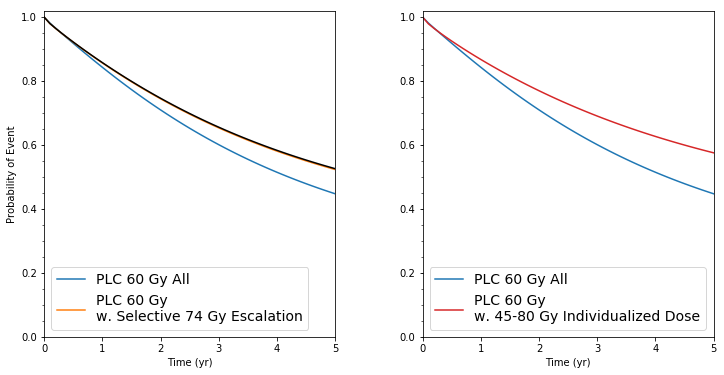

In [21]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize = (12,6),sharex=False)
    
"""------- first panel ---------"""
ax = axes[0]

ax.plot(t,plc_cohort_1_ave, label='PLC 60 Gy All')
ax.plot(t,plc_cohort_2_ave, label='PLC 60 Gy \nw. Selective 74 Gy Escalation')

ax.plot(t,plc_cohort_4_ave, color='k')


"""-------- second panel -----------"""
ax = axes[1]
        
ax.plot(t,plc_cohort_1_ave,label='PLC 60 Gy All')
ax.plot(t,plc_cohort_3_ave, color = cp[3],label='PLC 60 Gy \nw. 45-80 Gy Individualized Dose')


for i in range(axes.size):
    ax=axes[i]    
    ax.set_yticks(np.arange(0,1.2,.2),minor=False)

    ax.set_xticks(range(6))
    ax.set_xticklabels(list('012345'))
    ax.set_xlabel('Time (yr)')
    if i == 0: ax.set_ylabel('Probability of Event')
    ax.set_yticks(np.arange(0,1,.05),minor=True)
    ax.set_xbound(0,5)
    ax.set_ylim(0,1.02)
    ax.legend(fontsize=14)


fig.subplots_adjust(wspace=.3)


### combined 3 panel for fig #4

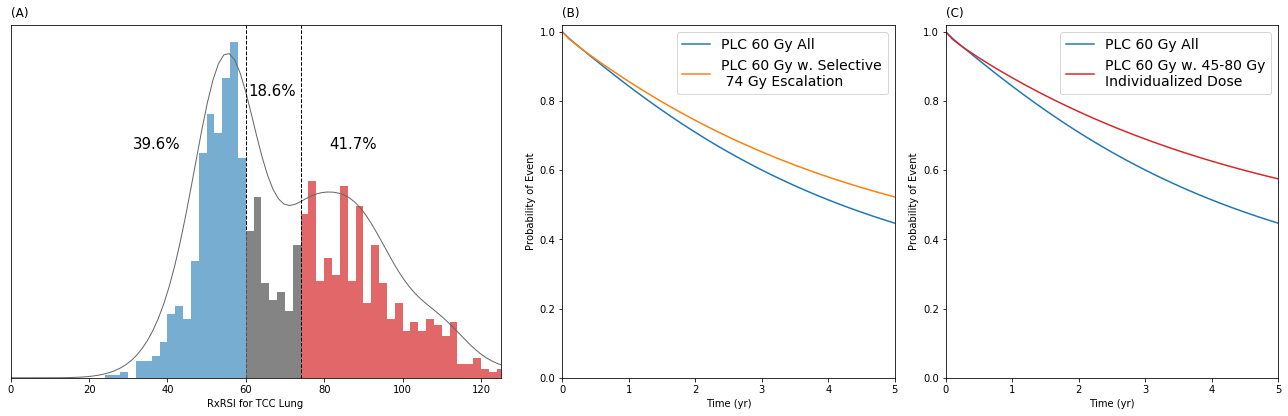

In [24]:
from matplotlib.gridspec import GridSpec

r = nsclc.rsi
d = 2
beta = 0.05
n = 1
alpha_tcc = (np.log(r)+beta*n*(d**2))/(-n*d)
rxdose_tcc = 33/(alpha_tcc+beta*d)
rxdose_tcc=rxdose_tcc.values

fig = plt.figure(figsize=(18,6))
gs1 = GridSpec(1, 1, figure=fig)
gs2 = GridSpec(1, 2, figure=fig)

""" ------------------plotting histogram--------------- """
ax = fig.add_subplot(gs1[0,0])

binlist=list(np.arange(0,150,2))+[300]

""" <60 range """
xdata = rxdose_tcc[np.where(rxdose_tcc<60)]
wts =  np.full(len(xdata),.0002)
ax.hist(xdata,bins = binlist,
        alpha=.6,#ec = 'k',
        color=cp[0],  
        weights = wts)

""" 60-74 range """
xdata = rxdose_tcc[np.where((rxdose_tcc>60)&(rxdose_tcc<74))]
wts =  np.full(len(xdata),.0002)
ax.hist(xdata,bins = binlist,
        alpha=.8,#ec = 'k',
        color=(.4,.4,.4),  
        weights = wts,zorder=5)

""" >74 range """
xdata = rxdose_tcc[np.where((rxdose_tcc>74))]  #&(rxdose_tcc<80))]
wts =  np.full(len(xdata),.0002)
ax.hist(xdata,bins = binlist,
        alpha=.7,#ec = 'k',
        color=cp[3],  
        weights = wts)

rxdose_kde = create_kde(rxdose_tcc,bandwidth=.15)

pp_60 = np.where(rxdose_kde[0]<=60,rxdose_kde[2],0).max()
pp_74 = np.where(rxdose_kde[0]<=74,rxdose_kde[2],0).max()
pp_60_74 = pp_74 - pp_60
pp_over_74 = 1 - pp_74

rxdose_kde = create_kde(rxdose_tcc,bandwidth=.26)
ax.plot(rxdose_kde[0], rxdose_kde[1] , c=(.4,.4,.4),lw=1,ls='-',label = 'KDE')

ax.text(.25,.65,'{:0.1f}%'.format(pp_60*100), transform=ax.transAxes, fontsize=15)
ax.text(.485,.8,'{:0.1f}%'.format(pp_60_74*100), transform=ax.transAxes,fontsize=15)
ax.text(.65,.65,'{:0.1f}%'.format(pp_over_74*100), transform=ax.transAxes,fontsize=15)

ax.axvline(x = 60,c='k',lw=1,ls='--')
ax.axvline(x = 74,c='k',lw=1,ls='--')

ax.set_xlim(0,125)
ax.set_yticks([])
ax.set_xlabel('RxRSI for TCC Lung')
ax.set_title('(A)',loc='left',pad=8)

    
"""------- second panel ---------"""
# ax = axes[1]
ax = fig.add_subplot(gs2[0,0])

ax.plot(t,plc_cohort_1_ave, label='PLC 60 Gy All')
ax.plot(t,plc_cohort_2_ave, label='PLC 60 Gy w. Selective\n 74 Gy Escalation')

ax.set_yticks(np.arange(0,1.2,.2),minor=False)
ax.set_xticks(range(6))
ax.set_xticklabels(list('012345'))
ax.set_xlabel('Time (yr)')
ax.set_ylabel('Probability of Event')
ax.set_xbound(0,5)
ax.set_ylim(0,1.02)
ax.legend(fontsize=14)
ax.set_title('(B)',loc='left',pad=8)

"""-------- third panel -----------"""
# ax = axes[2]
ax = fig.add_subplot(gs2[0,1])
        
ax.plot(t,plc_cohort_1_ave,label='PLC 60 Gy All')
ax.plot(t,plc_cohort_3_ave, color = cp[3],label='PLC 60 Gy w. 45-80 Gy\nIndividualized Dose')

   
ax.set_yticks(np.arange(0,1.2,.2),minor=False)
ax.set_xticks(range(6))
ax.set_xticklabels(list('012345'))
ax.set_xlabel('Time (yr)')
ax.set_ylabel('Probability of Event')

ax.set_xbound(0,5)
ax.set_ylim(0,1.02)
ax.legend(fontsize=14)
ax.set_title('(C)',loc='left',pad=8)

midpoint = 0.4
gs1.tight_layout(fig, rect=[0, 0, midpoint, .98])
gs2.tight_layout(fig, rect=[midpoint,0,1,.98])
# gs2.update(wspace=.35)

